In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alpho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [6]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\alpho\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)]]


In [12]:
id2word[0]

'addition'

In [13]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('brought', 1),
  ('called', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 1),
  ('doors', 1),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('il', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('lines', 1),
  ('looked', 1),
  ('looking', 1),
  ('made', 1),
  ('mail', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_posting', 1),
  ('organization', 1),
  ('park', 1),
  ('please', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('saw', 1),
  ('separate', 1),
  ('small', 1),
  ('specs', 1),
  ('sports', 1),
  ('tellme', 1),
  ('thanks', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('whatever', 1),
  ('wheres', 1),
  ('wondering', 1),
  ('years', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"year" + 0.009*"teams" + 0.009*"gun" + 0.009*"last" + 0.006*"kids" + '
  '0.006*"points" + 0.005*"hawks" + 0.005*"hit" + 0.005*"smith" + 0.005*"fbi"'),
 (1,
  '0.020*"gd" + 0.015*"islam" + 0.013*"cubs_suck" + 0.012*"moving" + '
  '0.007*"mt" + 0.007*"ei" + 0.007*"wt" + 0.007*"sk" + 0.007*"ul" + '
  '0.006*"rc"'),
 (2,
  '0.009*"reference" + 0.007*"yo" + 0.007*"standard" + 0.007*"oil" + '
  '0.007*"cost" + 0.007*"disk" + 0.007*"ibm" + 0.006*"price" + 0.006*"model" + '
  '0.006*"spanking"'),
 (3,
  '0.014*"mr_stephanopoulos" + 0.010*"said" + 0.009*"president" + 0.008*"day" '
  '+ 0.008*"went" + 0.008*"two" + 0.007*"three" + 0.007*"home" + 0.007*"power" '
  '+ 0.006*"days"'),
 (4,
  '0.024*"car" + 0.012*"bike" + 0.009*"cars" + 0.009*"road" + 0.007*"boston" + '
  '0.005*"ride" + 0.005*"speed" + 0.005*"rear" + 0.005*"coverage" + '
  '0.005*"hall"'),
 (5,
  '0.060*"max" + 0.022*"windows" + 0.013*"software" + 0.012*"file" + '
  '0.010*"using" + 0.010*"version" + 0.009*"files" + 

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.341551168014385

Coherence Score:  0.49115369835386796


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\alpho\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.344985 -0.045619       1        1  25.481527
6      0.191905  0.186752       2        1   8.333240
19     0.222693 -0.147206       3        1   7.668980
7      0.141876  0.142083       4        1   5.710675
3      0.085589 -0.118092       5        1   5.489089
5      0.033456  0.237848       6        1   4.738542
9      0.048859 -0.226261       7        1   4.497591
15    -0.060098  0.056333       8        1   4.442841
11    -0.082462  0.006830       9        1   4.346288
14    -0.006274  0.055896      10        1   3.869931
0     -0.055812 -0.095059      11        1   3.587865
2      0.016420  0.096028      12        1   3.381675
13    -0.065155 -0.055776      13        1   2.964972
17    -0.055850 -0.079656      14        1   2.797863
8     -0.063939 -0.100647      15        1   2.742302
4     -0.105176  0.046300      16        1   2.521682
10    -0.118295  0.002391      17        1   2.226988
1     -0.162232  0.008735      18        1   2.007547
12    -0.161570  0.036952      19        1   1.702348
16    -0.148918 -0.007834      20        1   1.488040, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
5128   Default  57151.000000              ax  57151.000000  30.0000  30.0000
23     Default  11366.000000           lines  11366.000000  29.0000  29.0000
33     Default  10841.000000    organization  10841.000000  28.0000  28.0000
4587   Default   4830.000000             max   4830.000000  27.0000  27.0000
167    Default   9411.000000           would   9411.000000  26.0000  26.0000
363    Default   7606.000000          writes   7606.000000  25.0000  25.0000
58     Default   7192.000000         article   7192.000000  24.0000  24.0000
49     Default   4941.000000      university   4941.000000  23.0000  23.0000
32     Default   4498.000000    nntp_posting   4498.000000  22.0000  22.0000
242    Default   6190.000000            dont   6190.000000  21.0000  21.0000
17     Default   4000.000000            host   4000.000000  20.0000  20.0000
463    Default   4898.000000          people   4898.000000  19.0000  19.0000
541    Default   8874.000000             one   8874.000000  18.0000  18.0000
138    Default   5821.000000            like   5821.000000  17.0000  17.0000
2295   Default   1920.000000           space   1920.000000  16.0000  16.0000
20     Default   5784.000000            know   5784.000000  15.0000  15.0000
364    Default   2152.000000            year   2152.000000  14.0000  14.0000
518    Default   2201.000000             god   2201.000000  13.0000  13.0000
1194   Default   2176.000000           jesus   2176.000000  12.0000  12.0000
233    Default   1775.000000         windows   1775.000000  11.0000  11.0000
1230   Default   2726.000000           right   2726.000000  10.0000  10.0000
632    Default   3636.000000            good   3636.000000   9.0000   9.0000
46     Default   1958.000000          thanks   1958.000000   8.0000   8.0000
164    Default   3608.000000            well   3608.000000   7.0000   7.0000
1      Default   2711.000000          anyone   2711.000000   6.0000   6.0000
1010   Default   4158.000000           think   4158.000000   5.0000   5.0000
798    Default   4406.000000            time   4406.000000   4.0000   4.0000
129    Default   4424.000000             get   4424.000000   3.0000   3.0000
224    Default   2544.000000          system   2544.000000   2.0000   2.0000
471    Default   2570.000000            said   2570.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
735    Topic20    250.126617             boy    251.106491   4.2038  -4.6201
9753   Topic20    232.467697         detroit    233.447571   4.2035  -4.6934
1050   Topic20    212.718674             tim    213.698547   4.2031  -4.78

In [20]:
filename = 'C:/Users/alpho/Dropbox/NLP - STEM/Presentation/lda_model_np'
outfile = open(filename,'wb')
pickle.dump(lda_model,outfile)
outfile.close()

filename = 'C:/Users/alpho/Dropbox/NLP - STEM/Presentation/corpus_np'
outfile = open(filename,'wb')
pickle.dump(corpus,outfile)
outfile.close()

filename = 'C:/Users/alpho/Dropbox/NLP - STEM/Presentation/id2word_np'
outfile = open(filename,'wb')
pickle.dump(id2word,outfile)
outfile.close()

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = lda_model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
 # Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

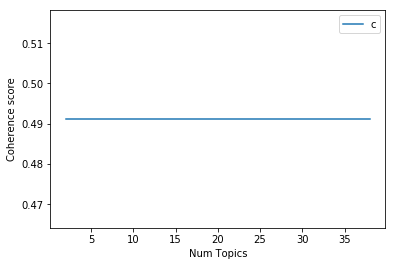

In [28]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4912
Num Topics = 8  has Coherence Value of 0.4912
Num Topics = 14  has Coherence Value of 0.4912
Num Topics = 20  has Coherence Value of 0.4912
Num Topics = 26  has Coherence Value of 0.4912
Num Topics = 32  has Coherence Value of 0.4912
Num Topics = 38  has Coherence Value of 0.4912


In [30]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.031*"year" + 0.009*"teams" + 0.009*"gun" + 0.009*"last" + 0.006*"kids" + '
  '0.006*"points" + 0.005*"hawks" + 0.005*"hit" + 0.005*"smith" + 0.005*"fbi"'),
 (1,
  '0.020*"gd" + 0.015*"islam" + 0.013*"cubs_suck" + 0.012*"moving" + '
  '0.007*"mt" + 0.007*"ei" + 0.007*"wt" + 0.007*"sk" + 0.007*"ul" + '
  '0.006*"rc"'),
 (2,
  '0.009*"reference" + 0.007*"yo" + 0.007*"standard" + 0.007*"oil" + '
  '0.007*"cost" + 0.007*"disk" + 0.007*"ibm" + 0.006*"price" + 0.006*"model" + '
  '0.006*"spanking"'),
 (3,
  '0.014*"mr_stephanopoulos" + 0.010*"said" + 0.009*"president" + 0.008*"day" '
  '+ 0.008*"went" + 0.008*"two" + 0.007*"three" + 0.007*"home" + 0.007*"power" '
  '+ 0.006*"days"'),
 (4,
  '0.024*"car" + 0.012*"bike" + 0.009*"cars" + 0.009*"road" + 0.007*"boston" + '
  '0.005*"ride" + 0.005*"speed" + 0.005*"rear" + 0.005*"coverage" + '
  '0.005*"hall"'),
 (5,
  '0.060*"max" + 0.022*"windows" + 0.013*"software" + 0.012*"file" + '
  '0.010*"using" + 0.010*"version" + 0.009*"files" + 